This is a small test using VGG16 for classifying different species of insects considered pests in agriculture. The dataset in question can be downloaded from the following link: https://www.kaggle.com/discussions/general/396597

This is a small test using VGG16 for classifying different species of insects considered pests in agriculture. The dataset in question can be downloaded from the following link: https://www.kaggle.com/discussions/general/396597

In [1]:
# Author: Xoan Fernandez Costas
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from torchvision.models import VGG16_Weights
from PIL import Image
from tempfile import TemporaryDirectory
import random
from google.colab import drive

In [2]:
# Load the data and apply transformations
drive.mount('/content/drive')

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = "/content/drive/MyDrive/cs231n/Data/archive"
data = datasets.ImageFolder(data_dir, transform=data_transform)

# Train the model on an available GPU. If the current accelerator
# is available, we will use it. Otherwise, we use the CPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda device


Divide the train and validation datasets

In [3]:
# Divide the dataset into training (80%) and validation sets (20%)
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

# Create training and validation dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
class_names = data.classes



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualize a few images

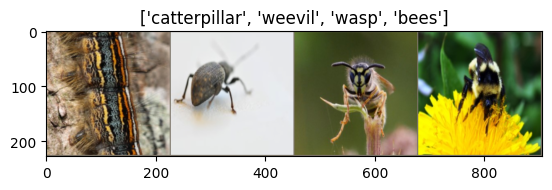

In [4]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) # From (C, H, W) to (H, W, C)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Pause a bit so that plots are updated

# Get a batch of the dataset
inputs, classes = next(iter(dataloaders['train']))

# Select a random sample from the batch
random_indices = random.sample(range(inputs.size(0)), 4)
selected_images = inputs[random_indices]

# Make a grid from batch
out = torchvision.utils.make_grid(selected_images)

imshow(out, title=[data.classes[classes[i]] for i in random_indices])

Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetunning the ConvNet

In [10]:
model_ft = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[6].in_features

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 12)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.7358 Acc: 0.2749
val Loss: 1.4727 Acc: 0.5114

Epoch 1/24
----------
train Loss: 1.2108 Acc: 0.5939
val Loss: 0.9603 Acc: 0.6606

Epoch 2/24
----------
train Loss: 0.7483 Acc: 0.7499
val Loss: 0.7157 Acc: 0.7662

Epoch 3/24
----------
train Loss: 0.4813 Acc: 0.8398
val Loss: 0.6385 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.3145 Acc: 0.8972
val Loss: 0.7057 Acc: 0.7853

Epoch 5/24
----------
train Loss: 0.2257 Acc: 0.9206
val Loss: 0.6598 Acc: 0.8171

Epoch 6/24
----------
train Loss: 0.1496 Acc: 0.9458
val Loss: 0.6793 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.0629 Acc: 0.9827
val Loss: 0.6267 Acc: 0.8335

Epoch 8/24
----------
train Loss: 0.0432 Acc: 0.9870
val Loss: 0.6473 Acc: 0.8335

Epoch 9/24
----------
train Loss: 0.0380 Acc: 0.9891
val Loss: 0.6599 Acc: 0.8362

Epoch 10/24
----------
train Loss: 0.0315 Acc: 0.9941
val Loss: 0.6871 Acc: 0.8362

Epoch 11/24
----------
train Loss: 0.0287 Acc: 0.9929
val Loss: 0.6818 Acc: 0.8380

Ep

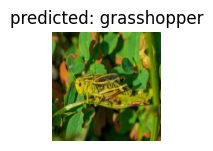

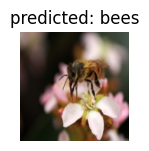

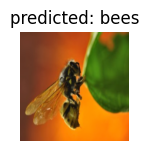

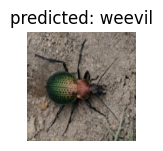

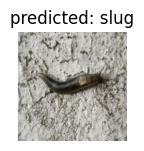

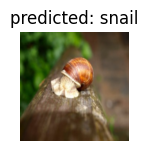

In [12]:
visualize_model(model_ft)

In [14]:
torch.save(model_ft.state_dict(), "vgg16_insect_classifier.pth")

Feature extraction with a pre-trained ConvNet

A pre-trained convolutional neural network (CNN) can be used as a **fixed feature extractor** by freezing its convolutional layers and only training new fully connected (FC) layers for a specific task. This technique is part of **transfer learning** and helps leverage learned representations from large datasets (e.g., ImageNet) without retraining the entire network.  

**Key benefits:**  
- Reduces training time  
- Prevents overfitting, especially with limited data  
- Extracts powerful features from images using a well-trained CNN  

In PyTorch, this is done by **freezing** the convolutional layers and replacing the classifier layers with a new head tailored to the target dataset.  

In [26]:
model_conv = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 12)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Train and Evaluate the model

In [28]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4750 Acc: 0.8464


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


val Loss: 0.4266 Acc: 0.8644

Epoch 1/24
----------
train Loss: 0.4063 Acc: 0.8687
val Loss: 0.4241 Acc: 0.8599

Epoch 2/24
----------
train Loss: 0.3755 Acc: 0.8728
val Loss: 0.4023 Acc: 0.8735

Epoch 3/24
----------
train Loss: 0.3555 Acc: 0.8780
val Loss: 0.3886 Acc: 0.8662

Epoch 4/24
----------
train Loss: 0.3411 Acc: 0.8856
val Loss: 0.3835 Acc: 0.8672

Epoch 5/24
----------
train Loss: 0.3224 Acc: 0.8917
val Loss: 0.3865 Acc: 0.8635

Epoch 6/24
----------
train Loss: 0.3142 Acc: 0.8974
val Loss: 0.3736 Acc: 0.8717

Epoch 7/24
----------
train Loss: 0.2980 Acc: 0.9031
val Loss: 0.3805 Acc: 0.8690

Epoch 8/24
----------
train Loss: 0.2881 Acc: 0.9051
val Loss: 0.3819 Acc: 0.8690

Epoch 9/24
----------
train Loss: 0.2871 Acc: 0.9031
val Loss: 0.3869 Acc: 0.8699

Epoch 10/24
----------
train Loss: 0.2716 Acc: 0.9133
val Loss: 0.3706 Acc: 0.8726

Epoch 11/24
----------
train Loss: 0.2692 Acc: 0.9122
val Loss: 0.3745 Acc: 0.8726

Epoch 12/24
----------
train Loss: 0.2598 Acc: 0.9113
v

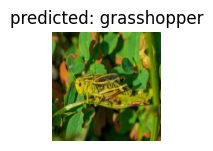

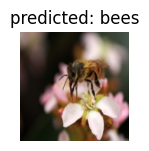

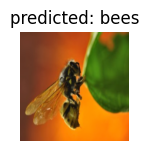

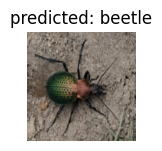

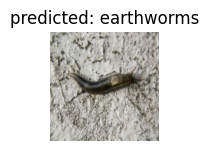

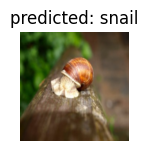

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [31]:
torch.save(model_ft.state_dict(), "vgg16_insect_classifier.pth")

Generalize on custom images

In [53]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    # Convertir imagen a numpy para visualizar
    img_np = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
    img_np = np.clip(img_np, 0, 1)  # Asegurar valores entre 0 y 1

    # Mostrar imagen con la predicción
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[preds[0]]}")

    model.train(mode=was_training)

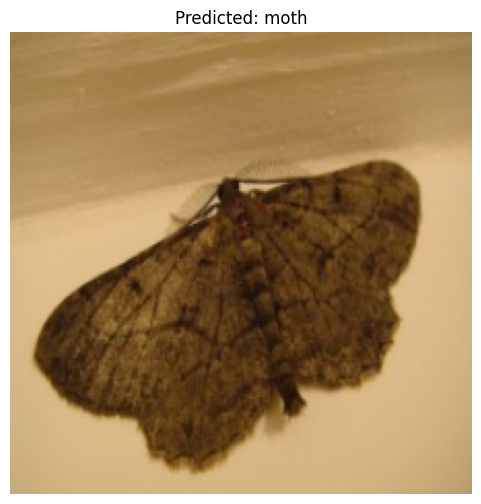

In [54]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/cs231n/Data/archive/moth/moth (111).jpg'
)

plt.ioff()
plt.show()